# Import libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd



repo_path = os.path.dirname(os.path.abspath(""))
CHECKOUT_PATH = repo_path
DATASET_PATH = os.path.join(repo_path, "datasets")

os.chdir(CHECKOUT_PATH)
sys.path.insert(0, CHECKOUT_PATH)

In [2]:
# import visualization packages
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
import astartes as at
from astartes import train_test_split, train_val_test_split

from ALineMol.utils import eval_roc_auc, eval_pr_auc, eval_acc, rescale, compute_linear_fit
from ALineMol.utils import plot_ID_OOD, plot_ID_OOD_sns
from ALineMol.utils import split_molecules_train_test, split_molecules_train_val_test

from ALineMol.splitters import ScaffoldSplit, RandomSplit, SphereExclusionSplit, KMeansSplit, DBScanSplit, OptiSimSplit

light_color = plt.get_cmap("plasma").colors[170]
#dark_color = plt.get_cmap("plasma").colors[5]
dark_color = "black"


#matplotlib.use("pgf")

matplotlib.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
        "font.size": 20,
        "text.usetex": True,
        "pgf.rcfonts": False,
    }
)

# Load Data and Split into Train and Test Sets 

In [3]:
DF_PATH = os.path.join(DATASET_PATH, "TDC", "CYP2C19", "CYP2C19_simplified.csv")
df = pd.read_csv(DF_PATH)
df.shape

(12665, 2)

In [75]:
## Making HIV dataset balanced
#df_balanced = pd.concat([df[df['label'] == 0].sample(2000), df[df['label'] == 1]]).sample(frac=1)
#df_balanced.to_csv(os.path.join(DATASET_PATH, "MoleculeNet", "HIV", "HIV_balanced.csv"), index=False)

In [6]:
#df = pd.read_csv(os.path.join(DATASET_PATH, "MoleculeNet", "HIV", "HIV_balanced.csv"))

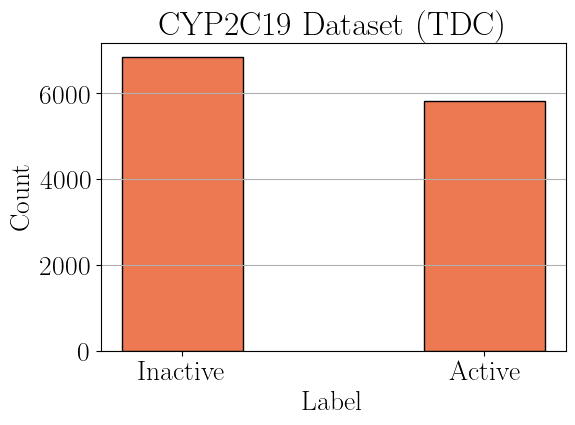

In [4]:
datset_category = "TDC"
dataset_name = "CYP2C19"
labels, counts = np.unique(df['label'], return_counts=True)
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, align='center', width=0.4, color=light_color, edgecolor=dark_color)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title(f"{dataset_name} Dataset ({datset_category})")
plt.xticks([0, 1], ["Inactive", "Active"])
plt.grid(True, axis='y')

#plt.savefig(os.path.join(repo_path, "assets", f"{dataset_name}_dataset.pdf"), bbox_inches='tight', backend='pgf')
#plt.savefig(os.path.join(repo_path, "assets", "hiv_dataset.svg"), bbox_inches='tight')
plt.show()

In [5]:
df['label'].value_counts(normalize=False)

label
0    6846
1    5819
Name: count, dtype: int64

In [6]:
X = np.array(df['smiles'])
y= np.array(df['label'])

In [6]:
#split_type="sphere_exclusion"
#hopts = {metrics: str = 'euclidean', distance_cutoff: float = 0.5}

#split_type="random"
#hopts={}

#split_type="scaffold"
#hopts={include_chirality: bool = False}

#split_type="kmeans"
#hopts={n_clusters=10, n_init=10}

#split_type="dbscan"
#hopts= {eps=0.5, metric="euclidean}"

#split_type="optisim"
#hopts= {n_clusters=10, max_subsample_size = 1000, distance_cutoff=0.1}"


In [9]:
dataset_category="TDC"
dataset_names="CYP2C19"
split_type="optisim"
filename="external_test.csv"
SPLIT_PATH = os.path.join(DATASET_PATH, dataset_category, dataset_names, "split")

train, external_test = split_molecules_train_test(df, sampler=split_type, train_size=0.9, random_state=42)

In [10]:
print(external_test.shape)
print(train.shape)

(1207, 2)
(11458, 2)


In [11]:
print(train['label'].sum() / train['label'].shape[0])
print(external_test['label'].sum() / external_test['label'].shape[0])

0.4602024786175598
0.4523612261806131


In [35]:
df['label'].shape

(12665,)

In [18]:
#train, val, test = split_molecules_train_val_test(train, train_size=0.7, val_size=0.15, sampler="random", random_state=42)

In [19]:
#print(train.shape, val.shape, test.shape, external_test.shape)

(25910, 2) (5552, 2) (5553, 2) (4112, 2)


In [12]:
train.to_csv(os.path.join(SPLIT_PATH, split_type, "train.csv"), index=False)
external_test.to_csv(os.path.join(SPLIT_PATH, split_type, "external_test.csv"), index=False)

In [11]:
pd.read_csv(os.path.join(SPLIT_PATH, split_type, "train.csv"))

,smiles,label
0,COc1ccc2[nH]cc(CCNc3cc(-c4cccc(C#N)c4)ncn3)c2c1,1
1,O=C(c1csnn1)N1CCC2(CCCN(c3ncccn3)C2)CC1,1
2,O=C(c1csnn1)N1CCC[C@@]2(CCN(c3ncccn3)C2)C1,0
3,O=C(c1csnn1)N1CCC2(CC1)CN(c1ncccn1)C2,0
4,CCOc1ccc(NC(=O)C(=O)NCC2CCCN2CC)cc1,0
...,...,...
11394,CN(C)S(=O)(=O)c1ccc(NC(=O)COC(=O)c2ccccn2)cc1,0
11395,O=C(c1ccncc1)N1CCC[C@@]2(CCN(Cc3cc(C(F)(F)F)cc...,0
11396,COc1ccc(C(=O)N2CCC3(CCCN(Cc4cc(C(F)(F)F)cc(C(F...,0
11397,COc1ccc(C(=O)N2CCC3(CCN(Cc4cc(C(F)(F)F)cc(C(F)...,0


In [29]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

In [29]:
test_df = pd.read_csv(os.path.join(SPLIT_PATH, split_type, "external_test.csv"))
predction_df = pd.read_csv(os.path.join(repo_path, "classification_inference_results", "prediction.csv"))

In [38]:
print(roc_auc_score(test_df['label'], predction_df['label']))
print(average_precision_score(test_df['label'], predction_df['label']))

0.5250719682081508
0.04230260423982137


In [47]:
test_df[(test_df.smiles  != predction_df.canonical_smiles)]

,smiles,label
1479,O=C1c2ccccc2C(=O)N1Cc1ccccc1-c1c2ccc(n2)c(-c2c...,0
2449,Cc1ccc(C=C2C=C3OC(=O)c4cccc(c43)C2=O)cc1,0
2450,O=C1OC2=CC(=Cc3ccccc3)C(=O)c3cccc1c32,0
2451,O=C1OC2=CC(=Cc3ccc([N+](=O)[O-])cc3)C(=O)c3ccc...,0
2545,Cc1cc(S(=O)(=O)Nc2nc3cccc4cccc([nH]2)c43)c(S)c...,0
3578,CCOC(=O)c1sc2nc(SC)nc3c2c1ncn3-c1ccc(Br)cc1,0
3579,CCOC(=O)c1sc2nc(SC)nc3c2c1ncn3-c1ccccc1Cl,0


In [48]:
predction_df[(test_df.smiles  != predction_df.canonical_smiles)]

,canonical_smiles,label
1479,O=C1c2ccccc2C(=O)N1Cc1ccccc1-c1c2nc(c(-c3ccccc...,0.033909
2449,Cc1ccc(C=c2cc3oc(=O)c4cccc(c4-3)c2=O)cc1,0.186460
2450,O=c1oc2cc(=Cc3ccccc3)c(=O)c3cccc1c3-2,0.023538
2451,O=c1oc2cc(=Cc3ccc([N+](=O)[O-])cc3)c(=O)c3cccc...,0.034584
2545,Cc1cc(S(=O)(=O)NC2=Nc3cccc4cccc(c34)N2)c(S)cc1Cl,0.156992
3578,CCOC(=O)c1sc2nc(SC)nc3c2c1N=CN3c1ccc(Br)cc1,0.000818
3579,CCOC(=O)c1sc2nc(SC)nc3c2c1N=CN3c1ccccc1Cl,0.000203


In [40]:
predction_df

,canonical_smiles,label
0,O=C1C(=Cc2cccc(Oc3ccccc3)c2)S(=O)(=O)C(c2ccccc...,0.075247
1,CC1C(=O)C2C1CS2(=O)=O,0.012605
2,COc1cc(C2(O)c3ccccc3C3=NCCN32)cc(OC)c1OC,0.367022
3,Cc1cc2c(C)n(Cc3ccc(Cl)cc3Cl)nc2c(C#N)c1C,0.006438
4,Cc1cc2c(C)n(Cc3ccc(Cl)cc3Cl)nc2c(C(=O)O)c1C,0.008149
...,...,...
4107,CCN(CC)CCOc1ccc(C(C#N)=Cc2ccc(OCCN3CCCCC3)cc2)cc1,0.181808
4108,Oc1ccc(C23CC4CC(CC(C4)C2)C3)cc1,0.064840
4109,COC(=O)c1cn2ccc3ccccc3c2c1C(=O)OC,0.002126
4110,c1csc(-c2cscc2-c2cccs2)c1,0.003083


In [37]:
roc_curve(test_df['label'], predction_df['label'])


3

In [5]:
from ALineMol.utils import eval_roc_auc, eval_pr_auc, eval_acc
df1= pd.read_csv(os.path.join(SPLIT_PATH, "scaffold", "external_test.csv"))
df2 = pd.read_csv(os.path.join(repo_path, "classification_inference_results", "prediction.csv"))

print(f"ROC-AUC score: {eval_roc_auc(df1, df2)}")
print(f"PR-AUC score: {eval_pr_auc(df1, df2)}")
print(f"Accuracy score: {eval_acc(df1, df2)}")

ROC-AUC score: 0.8156075856744038
PR-AUC score: 0.3042235499086715
Accuracy score: 0.9615758754863813


In [ ]:
exteral_test_path = os.path.join(SPLIT_PATH, "scaffold", "external_test.csv")
trained_model_path = os.path.join(repo_path, "classification_results", "HIV", "gin_supervised_contextpred", "1")
inference_result_path = os.path.join(repo_path, "classification_inference_results", "HIV", "gin_supervised_contextpred")

import subprocess
result = subprocess.run(["python", "scripts/classification_inference.py", "-f", "exteral_test_path", "-sc", "smiles", "-tp", "trained_model_path", "-ip", "inference_result_path", "-s"], shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
print(result)

In [19]:
trained_model_path

'/home/scholz/Documents/hfooladi/ALine/ALineMol/classification_results/HIV/gin_supervised_infomax/1'

# Investigate Accuracy-on-the-line

In [8]:
# accuracy, roc_auc or pr_auc
#Accuracy
dataset_category="TDC"
dataset_names="CYP2C19"
split_type="sphere_exclusion"
filename="external_test_05.csv"
SPLIT_PATH = os.path.join(DATASET_PATH, dataset_category, dataset_names, "split")


model_names=["GCN","GAT", "Weave", "MPNN", "AttentiveFP", "NF", "gin_supervised_contextpred", "gin_supervised_edgepred", "gin_supervised_masking", "gin_supervised_infomax"]
#model_names=["GCN"]
ID_test_accuracy=[]
OOD_test_accuracy=[]

ID_test_roc_auc=[]
OOD_test_roc_auc=[]

ID_test_pr_auc=[]
OOD_test_pr_auc=[]

for model_name in model_names:
    for i in range(43, 63):
        df = pd.read_csv(os.path.join("classification_results", dataset_category, dataset_names, model_name, str(i), "eval.txt"), sep=":", header=None)
        ID_test_accuracy.append(df.iloc[1, 1])
        ID_test_roc_auc.append(df.iloc[2, 1])
        ID_test_pr_auc.append(df.iloc[3, 1])


df1= pd.read_csv(os.path.join(SPLIT_PATH, split_type, filename))
for model_name in model_names:
    for i in range(43, 63):
        df = pd.read_csv(os.path.join("classification_inference_results", dataset_category, dataset_names, model_name, str(i), "prediction.csv"))
        OOD_test_accuracy.append(eval_acc(df1, df))
        OOD_test_roc_auc.append(eval_roc_auc(df1, df))
        OOD_test_pr_auc.append(eval_pr_auc(df1, df))

In [9]:
print(len(ID_test_accuracy))
print(len(ID_test_roc_auc))
print(len(ID_test_pr_auc))

print(len(OOD_test_accuracy))
print(len(OOD_test_roc_auc))
print(len(OOD_test_pr_auc))


200
200
200
200
200
200


In [10]:
models=[]
for model_name in model_names:
    for i in range(43, 63):
        models.append(model_name)

In [12]:
results = pd.DataFrame({"ID_test_accuracy": ID_test_accuracy, "OOD_test_accuracy": OOD_test_accuracy, "ID_test_roc_auc": ID_test_roc_auc, "OOD_test_roc_auc": OOD_test_roc_auc, "ID_test_pr_auc": ID_test_pr_auc, "OOD_test_pr_auc": OOD_test_pr_auc, "model": models})

In [13]:
probit_results = results.copy()
probit_results['ID_test_accuracy'] = rescale(results['ID_test_accuracy'], 'probit')
probit_results['OOD_test_accuracy'] = rescale(results['OOD_test_accuracy'], 'probit')
probit_results['ID_test_roc_auc'] = rescale(results['ID_test_roc_auc'], 'probit')
probit_results['OOD_test_roc_auc'] = rescale(results['OOD_test_roc_auc'], 'probit')
probit_results['ID_test_pr_auc'] = rescale(results['ID_test_pr_auc'], 'probit')
probit_results['OOD_test_pr_auc'] = rescale(results['OOD_test_pr_auc'], 'probit')

In [14]:
print("--------------------results-------------------")
print(compute_linear_fit(results['ID_test_accuracy'].values, results['OOD_test_accuracy'].values))
print(compute_linear_fit(results['ID_test_roc_auc'].values, results['OOD_test_roc_auc'].values))
print(compute_linear_fit(results['ID_test_pr_auc'].values, results['OOD_test_pr_auc'].values))
print("--------------------probit transform-------------------")
print(compute_linear_fit(probit_results['ID_test_accuracy'].values, probit_results['OOD_test_accuracy'].values))
print(compute_linear_fit(probit_results['ID_test_roc_auc'].values, probit_results['OOD_test_roc_auc'].values))
print(compute_linear_fit(probit_results['ID_test_pr_auc'].values, probit_results['OOD_test_pr_auc'].values))

--------------------results-------------------
(array([0.13831566, 0.73229516]), 0.2801751673102296)
(array([-0.00315076,  1.011568  ]), 0.8544862503925413)
(array([0.34979728, 0.6097679 ]), 0.4797723637390393)
--------------------probit transform-------------------
(array([0.00814377, 0.76393912]), 0.3133990773988832)
(array([0.03208615, 0.97169782]), 0.8546995461860109)
(array([0.40255244, 0.69278226]), 0.5140122932282465)


In [15]:
(bias, slope), r2 = compute_linear_fit(results['ID_test_accuracy'].values, results['OOD_test_accuracy'].values)

In [16]:
bias, slope, r2

(0.13831565572520677, 0.7322951628366815, 0.2801751673102296)

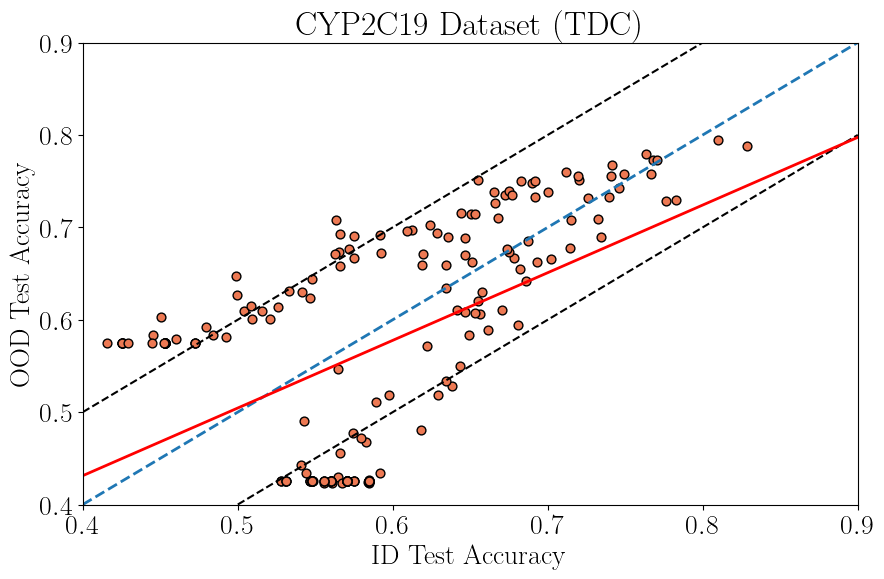

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(ID_test_accuracy, OOD_test_accuracy, color=light_color, s=40, edgecolor=dark_color, linewidth=1)
ax.axline((0.6, 0.6), slope=1, linestyle="--", linewidth=2)
ax.axline((0.5, 0.6), (1, 1.1), color=dark_color, linestyle="--")
ax.axline((0.5, 0.4), (1, 0.9), color=dark_color, linestyle="--")

ax.set_title(f"{dataset_names} Dataset ({dataset_category})")
ax.set_xlabel("ID Test Accuracy")
ax.set_ylabel("OOD Test Accuracy")


ax.set_xlim(0.4, 0.9)
ax.set_ylim(0.4, 0.9)

ax.grid(False)
ax.axline((0, bias), slope=slope, color='red', linewidth=2)

#fig.savefig(os.path.join(repo_path, "assets", "hiv_roc_auc_ID_OOD.pdf"), bbox_inches='tight', backend='pgf')
plt.show()

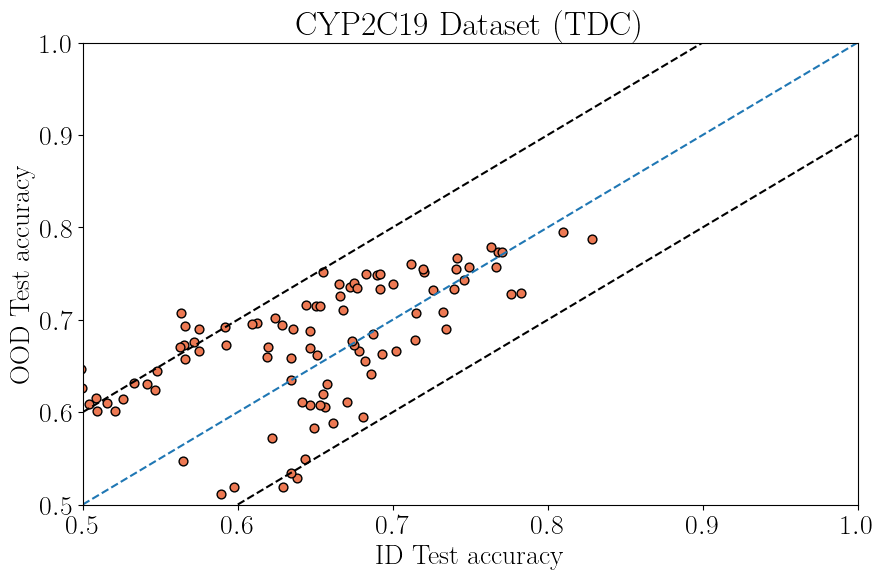

In [18]:
plot_ID_OOD(ID_test_accuracy, OOD_test_accuracy, dataset_category=dataset_category, dataset_name=dataset_names, metric="accuracy")

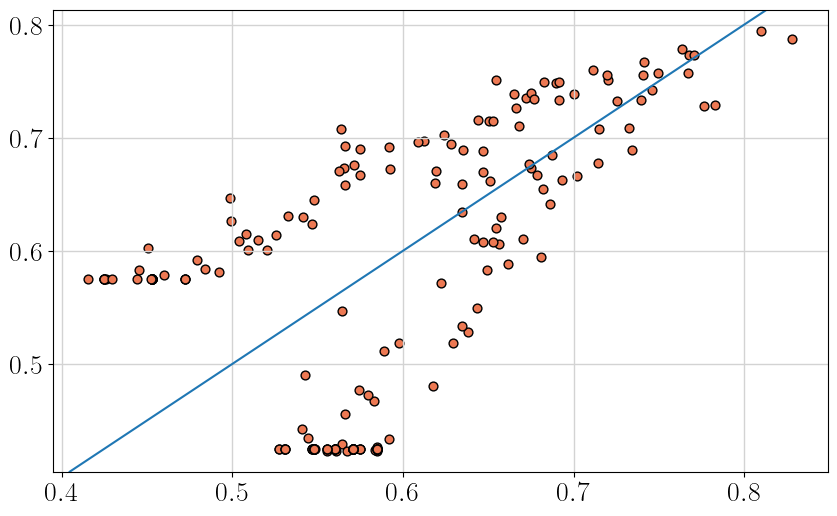

In [19]:
dffig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(ID_test_accuracy, OOD_test_accuracy, color=light_color, s=40, edgecolor=dark_color, linewidth=1)
ax.axline((0.6, 0.6), slope=1)
ax.grid(which='both', color='lightgray', linestyle='-', linewidth=1)

plt.show()

Text(0, 0.5, 'OOD Test Accuracy')

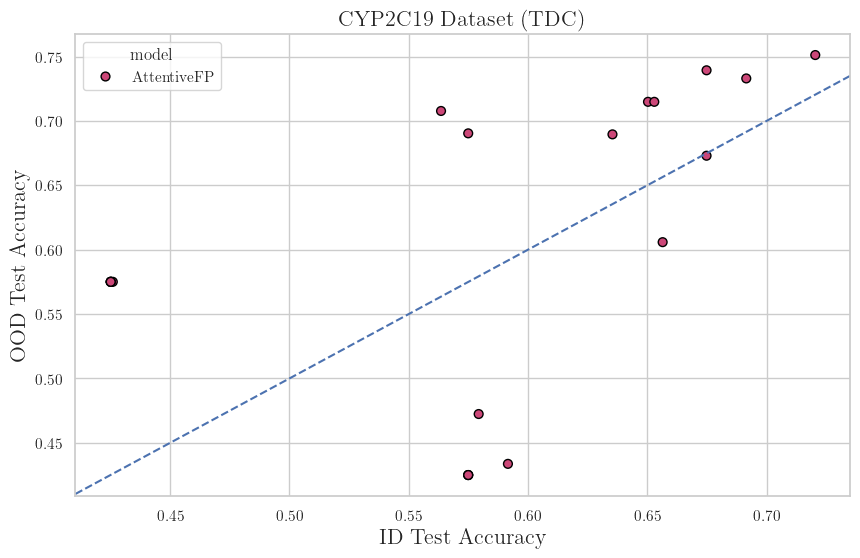

In [23]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.set_theme(style="whitegrid", rc={"text.usetex": True, "pgf.rcfonts": False, "font.serif": "Computer Modern Roman", "font.family": "serif"})

results_filter = results[results["model"] == "AttentiveFP"]
sns.scatterplot(data=results_filter, x='ID_test_accuracy', y='OOD_test_accuracy', hue='model', palette="plasma", s=40, ax=ax, edgecolor=dark_color, linewidth=1)
ax.axline((0.5, 0.5), slope=1, linestyle="--")

ax.set_title(f"{dataset_names} Dataset ({dataset_category})", fontsize=16)
ax.set_xlabel("ID Test Accuracy", fontsize=16)
ax.set_ylabel("OOD Test Accuracy", fontsize=16)


Text(0, 0.5, 'OOD Test Accuracy')

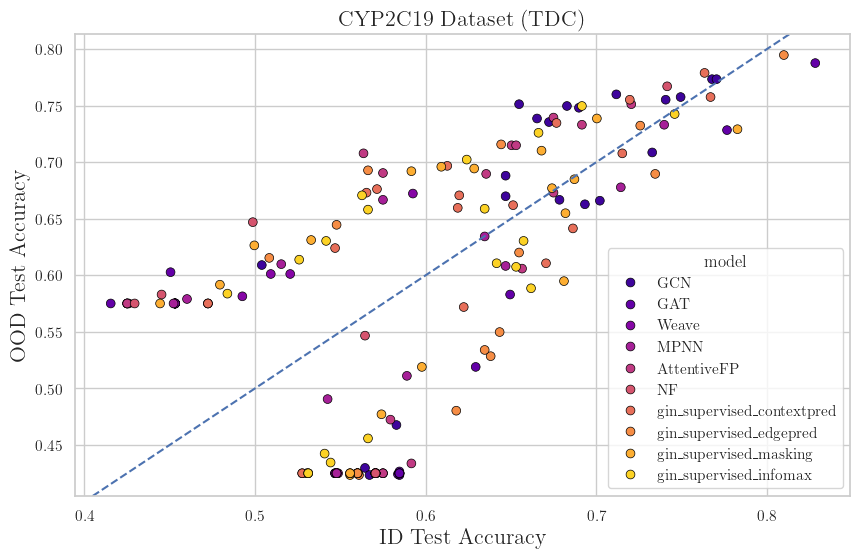

In [27]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.set_theme(style="whitegrid", rc={"text.usetex": True, "pgf.rcfonts": False, "font.serif": "Computer Modern Roman", "font.family": "serif"})

sns.scatterplot(data=results, x='ID_test_accuracy', y='OOD_test_accuracy', hue='model', palette="plasma", s=40, ax=ax, edgecolor=dark_color, linewidth=0.5)
ax.axline((0.6, 0.6), slope=1, linestyle="--")

ax.set_title(f"{dataset_names} Dataset ({dataset_category})", fontsize=16)
ax.set_xlabel("ID Test Accuracy", fontsize=16)
ax.set_ylabel("OOD Test Accuracy", fontsize=16)


Text(0, 0.5, 'OOD Test ROC-AUC')

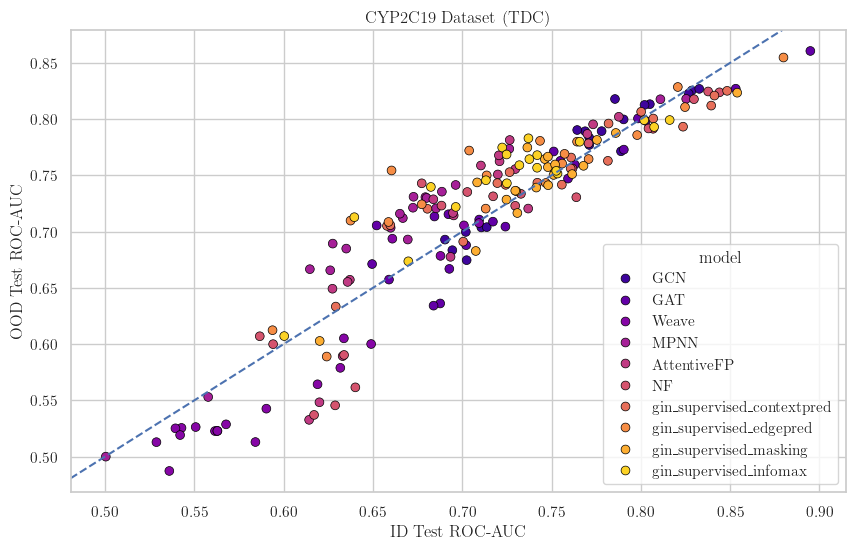

In [26]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.scatterplot(data=results, x='ID_test_roc_auc', y='OOD_test_roc_auc', hue='model', palette="plasma", s=40, ax=ax, edgecolor=dark_color, linewidth=0.5)
ax.axline((0.6, 0.6), slope=1, linestyle="--")

ax.set_title(f"{dataset_names} Dataset ({dataset_category})")
ax.set_xlabel("ID Test ROC-AUC")
ax.set_ylabel("OOD Test ROC-AUC")


Text(0, 0.5, 'OOD Test PR-AUC')

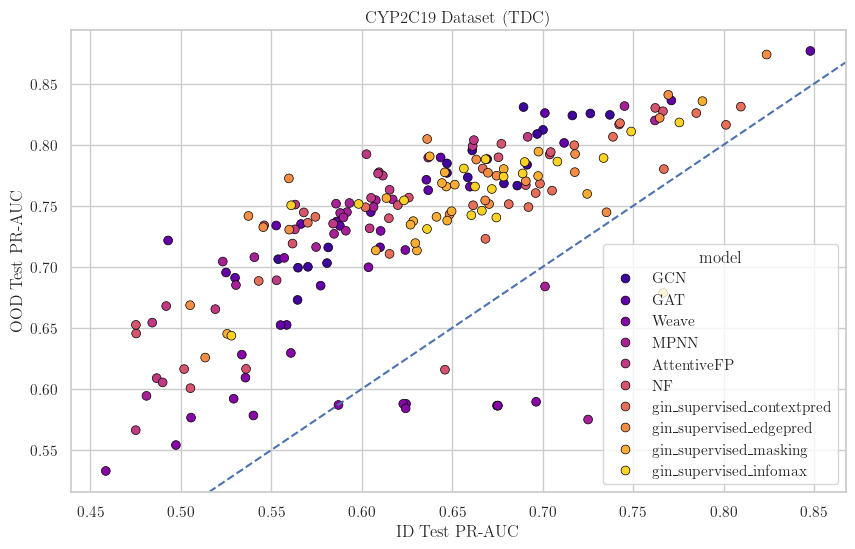

In [25]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.scatterplot(data=results, x='ID_test_pr_auc', y='OOD_test_pr_auc', hue='model', palette="plasma", s=40, ax=ax, edgecolor=dark_color, linewidth=0.5)
ax.axline((0.6, 0.6), slope=1, linestyle="--")

ax.set_title(f"{dataset_names} Dataset ({dataset_category})")
ax.set_xlabel("ID Test PR-AUC")
ax.set_ylabel("OOD Test PR-AUC")


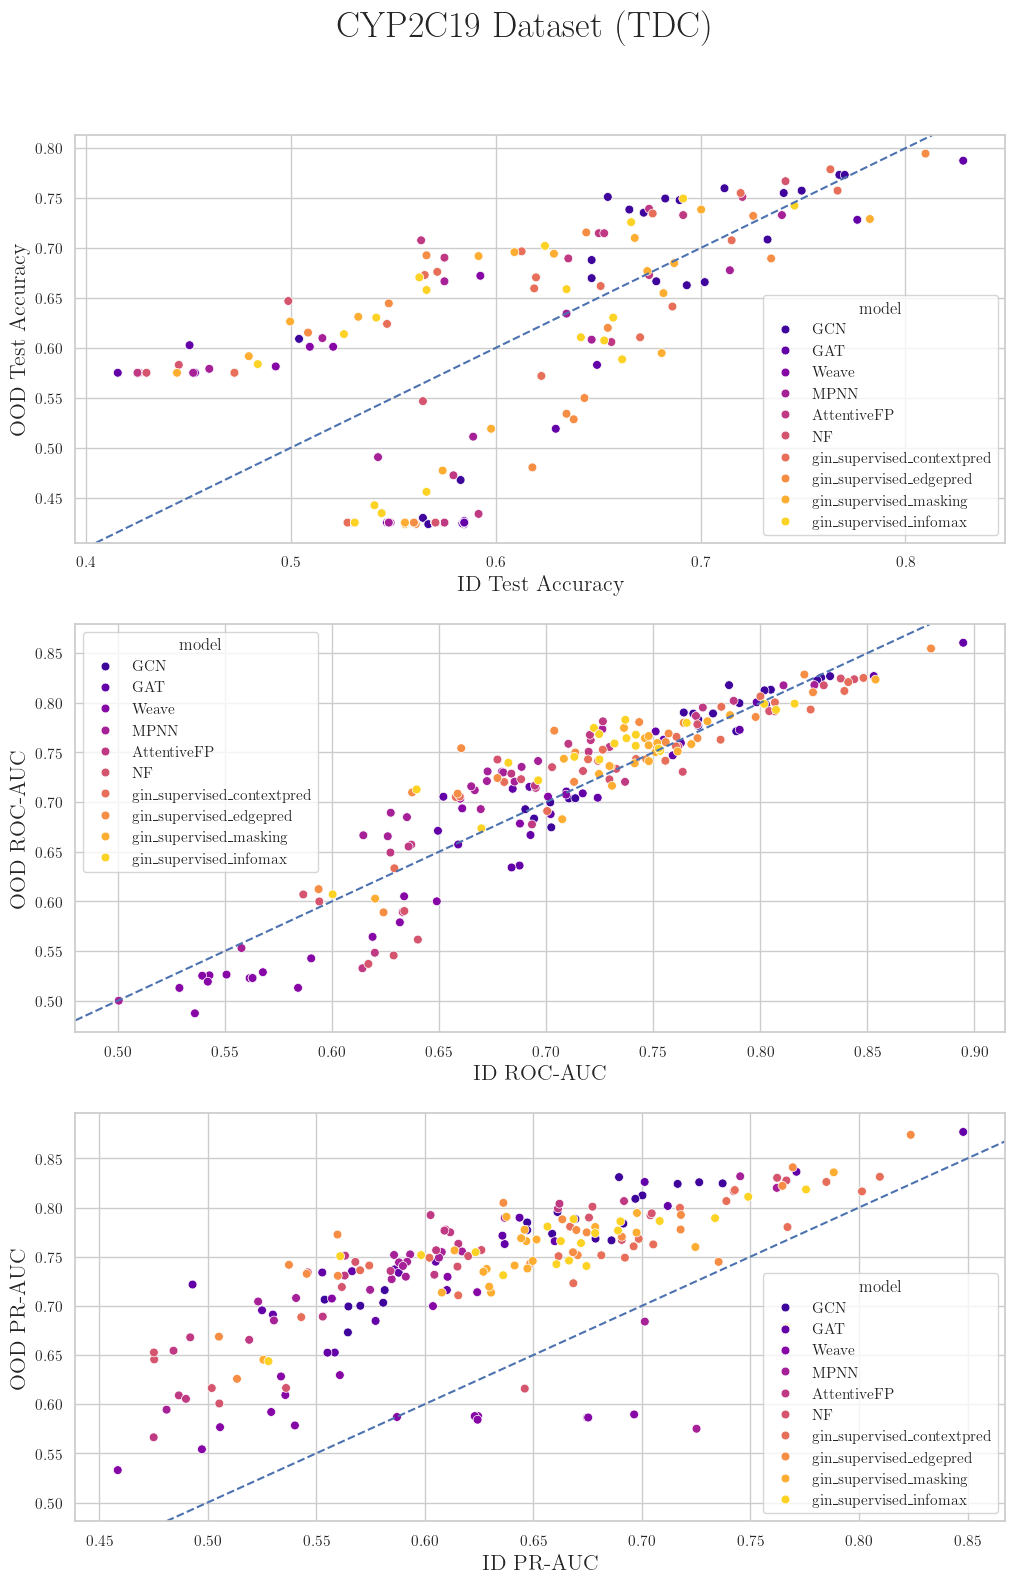

In [24]:
plot_ID_OOD_sns(results)

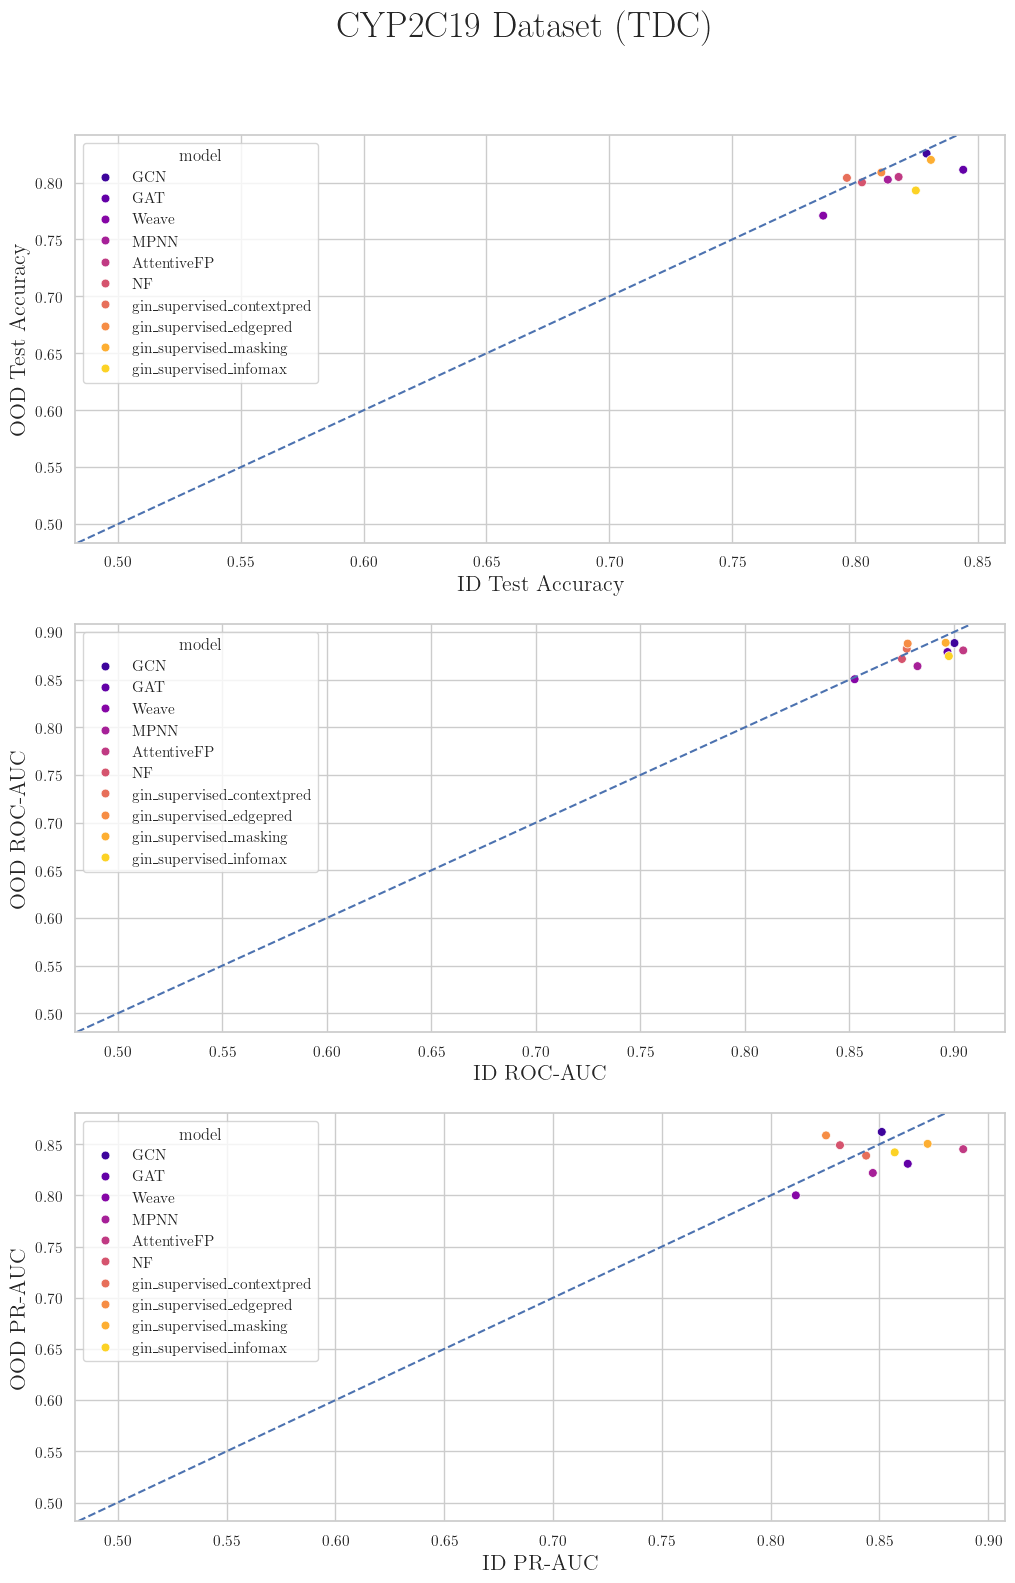

In [19]:
fig, ax = plt.subplots(3, 1, figsize=(12, 18))
sns.set_theme(style="whitegrid", rc={"text.usetex": True, "pgf.rcfonts": False, "font.serif": "Computer Modern Roman", "font.family": "serif"})

fig.suptitle(f"{dataset_names} Dataset ({dataset_category})", fontsize=26, y=0.95)
sns.scatterplot(data=results, x="ID_test_accuracy", y="OOD_test_accuracy", hue="model", palette="plasma", s=40, ax=ax[0])
ax[0].axline((0.5, 0.5), slope=1, linestyle="--")

ax[0].set_xlabel("ID Test Accuracy", fontsize=16)
ax[0].set_ylabel("OOD Test Accuracy", fontsize=16)

sns.scatterplot(data=results, x="ID_test_roc_auc", y="OOD_test_roc_auc", hue="model", palette="plasma", s=40, ax=ax[1])
ax[1].axline((0.5, 0.5), slope=1, linestyle="--")

ax[1].set_xlabel("ID ROC-AUC", fontsize=16)
ax[1].set_ylabel("OOD ROC-AUC", fontsize=16)

sns.scatterplot(data=results, x="ID_test_pr_auc", y="OOD_test_pr_auc", hue="model", palette="plasma", s=40, ax=ax[2])
ax[2].axline((0.5, 0.5), slope=1, linestyle="--")

ax[2].set_xlabel("ID PR-AUC", fontsize=16)
ax[2].set_ylabel("OOD PR-AUC", fontsize=16)

plt.show()

In [20]:
results

,ID_test_accuracy,OOD_test_accuracy,ID_test_roc_auc,OOD_test_roc_auc,ID_test_pr_auc,OOD_test_pr_auc,model
0,0.829097,0.825434,0.900388,0.888539,0.851073,0.862054,GCN
1,0.843996,0.811216,0.897043,0.879085,0.863010,0.830935,GAT
2,0.787029,0.770932,0.852618,0.850554,0.811579,0.800101,Weave
3,0.813322,0.802528,0.882701,0.864293,0.846963,0.821981,MPNN
4,0.817704,0.804897,0.904579,0.880810,0.888492,0.845218,AttentiveFP
5,0.802805,0.800158,0.875259,0.871834,0.831855,0.849081,NF
6,0.796670,0.804107,0.877549,0.882559,0.843877,0.838896,gin_supervised_contextpred
7,0.810692,0.808847,0.877998,0.887978,0.825451,0.858657,gin_supervised_edgepred
8,0.830850,0.819905,0.896177,0.888854,0.872136,0.850410,gin_supervised_masking
9,0.824715,0.793049,0.897698,0.874836,0.857008,0.842093,gin_supervised_infomax


In [10]:
model_name="Weave"
!cat classification_results/HIV/$model_name/1/eval.txt | head -2 | tail -1 | cut -d : -f 2

 0.7527920148160909


In [15]:
df = pd.read_csv(os.path.join("classification_results", "HIV", "GCN" , "1", "eval.txt"), sep=":", header=None)

In [5]:
from dgllife.utils import PretrainAtomFeaturizer, PretrainBondFeaturizer

In [8]:
from rdkit import Chem
import torch
mol = Chem.MolFromSmiles(df["smiles"][0])

In [40]:
edge_features = []
num_bonds = mol.GetNumBonds()

In [46]:
for j, smile in enumerate(df["smiles"]):
    mol = Chem.MolFromSmiles(smile)
    num_bonds = mol.GetNumBonds()
    for i in range(num_bonds):
        bond = mol.GetBondWithIdx(i)
        bond_feature = bond.GetBondType().__str__()
        if bond_feature == "DATIVE":
            print(j)
        edge_features.append(bond_feature)

In [47]:
df.to_csv(os.path.join(repo_path, "datasets", "MoleculeNet", "HIV", "split", "scaffold", "train.csv"), index=False)

In [35]:
from collections import Counter
Counter(edge_features)

Counter({'SINGLE': 554463,
         'AROMATIC': 471587,
         'DOUBLE': 99070,
         'TRIPLE': 4566,
         'DATIVE': 2})

In [6]:
edge_features = []
num_bonds = mol.GetNumBonds()
if num_bonds == 0:
    assert self._self_loop, \
        'The molecule has 0 bonds and we should set self._self_loop to True.'

# Compute features for each bond
for i in range(num_bonds):
    bond = mol.GetBondWithIdx(i)
    bond_feats = [
        self._bond_types.index(bond.GetBondType()),
        self._bond_direction_types.index(bond.GetBondDir())
    ]
    edge_features.extend([bond_feats, bond_feats.copy()])

if self._self_loop:
    self_loop_features = torch.zeros((mol.GetNumAtoms(), 2), dtype=torch.int64)
    self_loop_features[:, 0] = len(self._bond_types)

if num_bonds == 0:
    edge_features = self_loop_features
else:
    edge_features = np.stack(edge_features)
    edge_features = F.zerocopy_from_numpy(edge_features.astype(np.int64))
    if self._self_loop:
        edge_features = torch.cat([edge_features, self_loop_features], dim=0)

,smiles,label
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,0
4,O=S(=O)(O)CCS(=O)(=O)O,0
...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,0
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,0
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,0
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,0


In [3]:
df = pd.read_csv(os.path.join(DATASET_PATH, "TDC", "CYP2C19", "cyp2c19_veith.tab"), sep="\t")

In [4]:
SPLIT_PATH = os.path.join(DATASET_PATH, "TDC", "CYP2C19", "split", "scaffold")

In [7]:
df = df[['Drug', 'Y']]
df.columns = ['smiles', 'label']
df.to_csv(os.path.join(DATASET_PATH, "TDC", "CYP2C19", "CYP2C19_simplified.csv"), index=False)

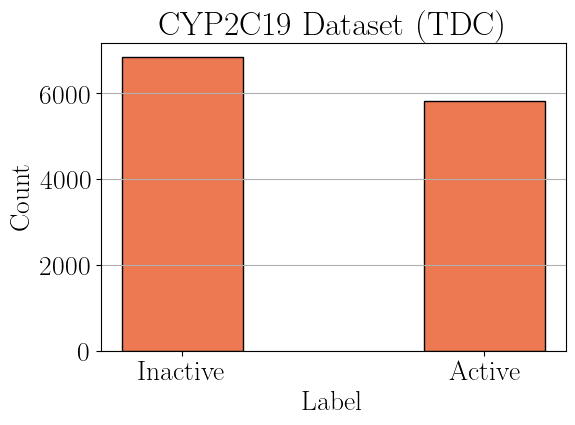

In [24]:
labels, counts = np.unique(df['label'], return_counts=True)
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, align='center', width=0.4, color=light_color, edgecolor=dark_color)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("CYP2C19 Dataset (TDC)")
plt.xticks([0, 1], ["Inactive", "Active"])
plt.grid(True, axis='y')

plt.savefig(os.path.join(repo_path, "assets", "cyp2c19_dataset.pdf"), bbox_inches='tight', backend='pgf')
#plt.savefig(os.path.join(repo_path, "assets", "hiv_dataset.svg"), bbox_inches='tight')
plt.show()

In [28]:
df['label'].value_counts(normalize=False)

label
0    6846
1    5819
Name: count, dtype: int64

In [13]:
np.unique(df['label'], return_counts=True)

(array([0, 1]), array([6846, 5819]))

In [4]:
from tdc.single_pred import ADME
data = ADME(name = 'CYP2C19_Veith')
split = data.get_split(method="scaffold")

Downloading...


100%|██████████| 771k/771k [00:00<00:00, 1.86MiB/s]
Loading...
Done!
100%|██████████| 12665/12665 [00:03<00:00, 3923.15it/s]


In [6]:
SPLIT_PATH = os.path.join(DATASET_PATH, "TDC", "CYP2C19", "split", "scaffold")

external_test = split['test']
external_test = external_test[['Drug', 'Y']]
external_test.columns = ['smiles', 'label']
external_test.to_csv(os.path.join(SPLIT_PATH, "external_test_TDC.csv"), index=False)

train = pd.concat([split['train'], split['valid']])
train = train[['Drug', 'Y']]
train.columns = ['smiles', 'label']
train.to_csv(os.path.join(SPLIT_PATH, "train_TDC.csv"), index=False)

In [6]:
fingerprint="morgan_fingerprint"
fprints_hopts={
    "radius": 2,
    "n_bits": 2048,
}
from ALineMol.utils.split_utils import compute_similarities, featurize

#external_test = pd.read_csv(os.path.join(SPLIT_PATH, "sphere_exclusion", "external_test.csv"))
#train = pd.read_csv(os.path.join(SPLIT_PATH, "sphere_exclusion", "train.csv"))

#compute_similarities(external_test['smiles'].values, train['smiles'].values, fingerprint=fingerprint, fprints_hopts=fprints_hopts)

In [7]:
from scipy.spatial import distance
from typing import List, Union, Dict
def compute_similarities(source_molecules: Union[List, np.ndarray], target_molecules: Union[List, np.ndarray], fingerprint: str, fprints_hopts: Dict) -> np.ndarray:
    """
    Compute similarities between two lists of molecules. It receives two lists of
    smiles or RDKit molecule objects, extracts their fingerprints and computes the similarities
    between them.

    Args:
        source_molecules (np.array or list): SMILES strings or RDKit molecule objects.
        target_molecules (np.array or list): SMILES strings or RDKit molecule objects.
        fingerprint (str): The molecular fingerprint to be used.
        fprints_hopts (dict): Hyperparameters for AIMSim.

    Returns:
        np.ndarray: Matrix of similarities between the two lists of molecules
    """
    fps1 = featurize(source_molecules, fingerprint, fprints_hopts)  # assumed train set
    fps2 = featurize(target_molecules, fingerprint, fprints_hopts)  # assumed test set
    sims = 1 - distance.cdist(fps1, fps2, metric="jaccard")
    return sims.astype(np.float32)

In [8]:
smis = compute_similarities(train['smiles'].values, external_test['smiles'].values, fingerprint, fprints_hopts)

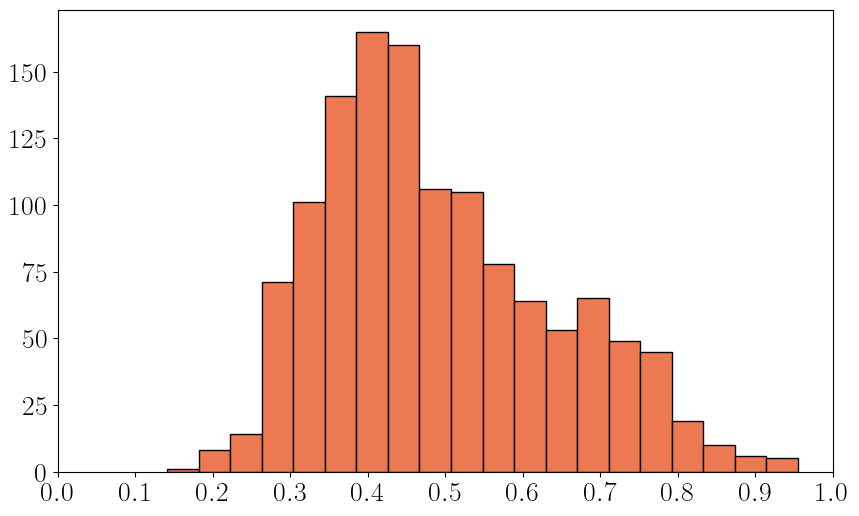

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(smis.max(axis=0), bins=20, color=light_color, edgecolor=dark_color)
ax.set_xticks(np.arange(0, 1.1, 0.1))
plt.show()

In [12]:
compute_similarities(["CCO"], ["CCO"], fingerprint, fprints_hopts)

array([[1.]], dtype=float32)